In [492]:
%matplotlib inline
from scipy import io
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

#### Loading train,validate and test set 

In [35]:
data = io.loadmat("ex5data1.mat")
X = data['X']
y = data['y']
X_test = data['Xtest']
y_test = data['ytest']
X_val = data['Xval']
y_val = data['yval']

#### Plot training data for visualization

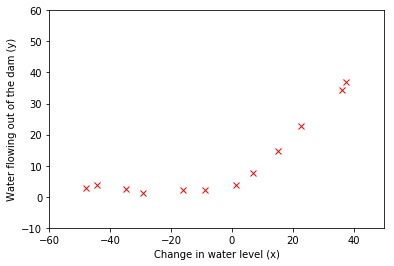

In [36]:
plt.plot(X,y, 'rx')
plt.axis([-60, 50, -10, 60])
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

#### Save training data mean and range for scaling

In [ ]:
TRAINING_SET_MEAN = np.mean(X, axis=0)
TRAINING_SET_RANGE = np.max(X, axis=0) - np.min(X, axis=0)

#### Compute regularized linear regression cost function

In [4]:
def ln_regularized(Weights,num_examples, _lbd):
    """
    Input:
        Weights (ndarray) : Model Weights 
        _lbd (float)  : value of regularized term
    Output:
        Regularized (float) 
    """
    Regularized = np.dot(Weights[1:].ravel(), Weights[1:].ravel()) * (_lbd/(2*num_examples))
    return Regularized

In [107]:
def linear_regression_cost(X, y, Weights, _lbd=0):
    """
    Input : X (ndarray) : training set input
            y (ndarray) : training set output
            Weights (ndarray) : model Weights that out cost function based on
            _lbd (float) : model regularized term
            
    Output: Cost (float) : current model cost
    """
    Cost = 0.0
    m, _ = X.shape
    
    X_bias = np.insert(X, 0, 1, axis=1)
    
    hypo = np.dot(X_bias, Weights)
    Cost = np.dot((hypo - y).T, hypo - y) / (2*m)
    Regularized = ln_regularized(Weights, m, _lbd)
    
    return Cost + Regularized

#### Unit test our cost function with weights = [1,1] and $\lambda$=1.This cost should be 303.993

In [108]:
initial_weights = np.array([[1],[1]])
linear_regression_cost(X, y, initial_weights, 1)

array([[ 303.99319222]])

#### Compute regularized linear regression gradient

In [127]:
def linear_regression_gradient(X, y, Weights, alpha=0.1, _lbd=0):
    """
    Input:
        X (ndarray) : training set input
        y (ndarray) : training set ouput
        Weights (ndarray) : Current model Weights
        alpha (float) : learning rate
        _lbd (float) : regularized term
        
    Output : 
        Weight_grad (ndarray) : gradient of linear regression
    """
    m,_ = X.shape
    X_ = np.insert(X, 0, 1, axis=1)
    Weight_grad = np.zeros(Weights.shape)
    Weight_grad = np.dot(X_.T, np.dot(X_, Weights) - y) * (alpha/m)
    Weight_grad[1:] +=  Weights[1:] * (_lbd/m)
    
    return Weight_grad

#### Unit test out linear regression gradient function with Weights = [1,1] , $\lambda$=1, and learning rate $\alpha$=1.This value should be [-15.30, 598.250]

In [128]:
initial_weights = np.array([[1],[1]])
linear_regression_gradient(X, y, initial_weights, alpha=1, _lbd=1)

array([[ -15.30301567],
       [ 598.25074417]])

#### Training linear regression model

In [193]:
def linear_regression_training(X, y, alpha=0.1, _lbd=0, num_iters=200):
    """
    Training linear regression model using gradient descent, to find the optimal weights.
    Input :
            X (ndarray) : training set input
            y (ndarray) : training set output
            _lbd (float) : regularized term
    Output: 
            weights (ndarray) : optimal weights of linear regression model
    """
    
    weights = np.zeros((X.shape[1]+1, 1))
    
    # features scaling
    
    for i in range(num_iters):
        weights -= linear_regression_gradient(X, y, weights, alpha, _lbd)
                       
    return weights

In [212]:
X_scale = (X - TRAINING_SET_MEAN) / TRAINING_SET_RANGE
model_weights = linear_regression_training(X_scale[0:3,:], y[0:3], alpha=1, _lbd=1, num_iters=200)
linear_regression_cost(X_scale[0:3, :], y[0:3], model_weights, 0)

array([[ 69.03919606]])

#### Plot our training data and our prediction model

#### Important : Understand why the plot works???

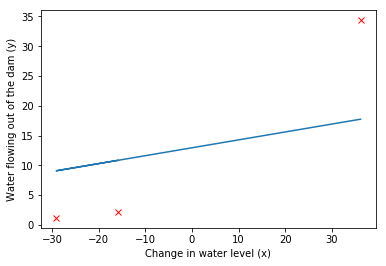

In [213]:
plt.plot(X[0:3, :], y[0:3], 'rx', X[0:3,:], np.dot(np.insert(X_scale[0:3,:], 0, 1, axis=1), model_weights))
plt.xlabel('Change in water level (x)')
plt.ylabel('Water flowing out of the dam (y)')
plt.show()

#### Compute learning curve of our linear regression model

In [195]:
def learning_curve(X, y, Xval, yval, lbd=0):
    """
    Compute learning curve of our current linear regression model
    Input : 
        X (ndarray) : training set input
        y (ndarray) : training set output
        Xval (ndarray) : cross-validation set input
        yval (ndarray) : cross-validation set output
        lbd (float) : regularized term
    Output:
        (error_train, error_validation) (tuple) : model error correctspond to training set 
        and validation set when number of training example inscrease
    """
    
    m,_ = X.shape
    error_train = np.zeros((m, 1))
    error_validation = np.zeros((m, 1))
    
    X_scale = (X - TRAINING_SET_MEAN) / TRAINING_SET_RANGE
    X_val_scale = (Xval - TRAINING_SET_MEAN) / TRAINING_SET_RANGE
    for i in range(0, m):
        X_i = X_scale[0:i+1,:]
        y_i = y[0:i+1]
        weights = linear_regression_training(X_i, y_i, 1, lbd)
        error_train[i] = linear_regression_cost(X_i, y_i, weights, 0)
        error_validation[i] = linear_regression_cost(X_val_scale, yval, weights, 0)
        
    return (error_train, error_validation)

In [530]:
def plot_learning_curve(X, y, Xval, yval, lbd):
    err_train,err_validation = learning_curve(X, y, Xval, yval, lbd)
    m,_ = X.shape
    for i in range(m):
        print(err_train[i], err_validation[i])
    plt.plot(range(0, m), err_train, label='Train error')
    plt.title('Learning curve for linear regression')
    plt.plot(range(0, m), err_validation, label='Validation error')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.legend(["Train error", "Validation error"])
    plt.show()    

[ 0.] [ 140.18878295]
[ 0.01285298] [ 120.90330258]
[ 3.28659505] [ 45.01023137]
[ 2.84267769] [ 48.36891137]
[ 13.15404881] [ 35.86516475]
[ 19.44396251] [ 33.8299616]
[ 20.09852166] [ 31.9709858]
[ 18.1728587] [ 30.86244632]
[ 22.60940542] [ 31.13599795]
[ 23.26146159] [ 28.93620747]
[ 24.31724959] [ 29.55143162]
[ 22.3739065] [ 29.43381813]


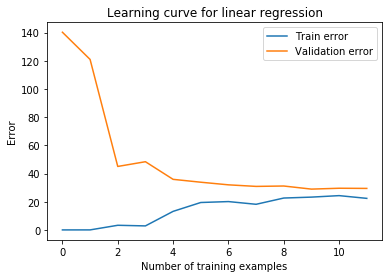

In [532]:
TRAINING_SET_MEAN = np.mean(X, axis=0)
TRAINING_SET_RANGE = np.max(X, axis=0) - np.min(X, axis=0)
plot_learning_curve(X, y, X_val, y_val, 0)

In [559]:
poly = PolynomialFeatures(8, include_bias=False)
X_poly = poly.fit_transform(X)
X_val_poly = poly.fit_transform(X_val)
TRAINING_SET_MEAN = np.mean(X_poly, axis=0)
TRAINING_SET_RANGE = np.max(X_poly, axis=0) - np.min(X_poly, axis=0)

[ 0.] [ 138.84677698]
[ 0.06606404] [ 143.80711459]
[ 7.66845436] [ 4.30488358]
[ 4.31173507] [ 3.8940722]
[ 3.40277989] [ 3.84876044]
[ 2.66621564] [ 4.48754879]
[ 2.83820031] [ 3.83242574]
[ 2.45354364] [ 3.87467426]
[ 2.48257734] [ 4.33504964]
[ 2.27551378] [ 4.21880476]
[ 2.05546107] [ 4.34131892]
[ 2.87770891] [ 3.55318613]


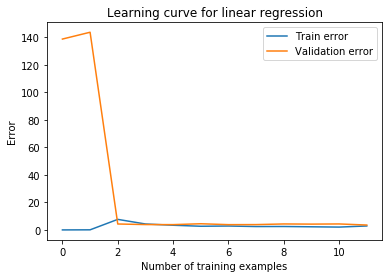

In [565]:
plot_learning_curve(X_poly, y, X_val_poly, y_val, 0.2)

#### Using Scikit Learn Linear Regression

In [467]:
def sk_learning_curve(X, y, Xval, yval, lbd):
    m,_ = X.shape
    err_train = np.zeros((m, 1))
    err_validate = np.zeros((m, 1))
    lr = Ridge(alpha=lbd)
    for i in range(m):
        lr.fit(X[0:i+1,:], y[0:i+1])
        err_train[i] = mean_squared_error(lr.predict(X[0:i+1,:]), y[0:i+1])
        err_validate[i] = mean_squared_error(lr.predict(Xval), yval)
        
    return (err_train, err_validate)

In [575]:
def visualize_learning_curve(X, y, X_val, y_val, lbd=0):
    err_train, error_validate = sk_learning_curve(X, y, X_val, y_val, lbd)
    for i in range(err_train.shape[0]):
        print(err_train[i], error_validate[i])
    plt.plot(range(err_train.shape[0]), err_train)
    plt.plot(range(error_validate.shape[0]), error_validate)
    plt.legend(["Train error", "Validation error"])
    plt.title('Learning curve for linear regression')
    plt.xlabel('Number of training examples')
    plt.ylabel('Error')
    plt.show()

[ 0.] [ 277.69355395]
[ 0.00243727] [ 226.96378421]
[ 6.57721487] [ 89.26266651]
[ 5.68751116] [ 96.14232479]
[ 26.30876375] [ 71.59828979]
[ 38.88849722] [ 67.51443779]
[ 40.19746667] [ 63.83380144]
[ 36.34602056] [ 61.64860882]
[ 45.21906591] [ 62.20917432]
[ 46.52308511] [ 57.8519165]
[ 48.63463185] [ 59.09534239]
[ 44.74792689] [ 58.85492854]


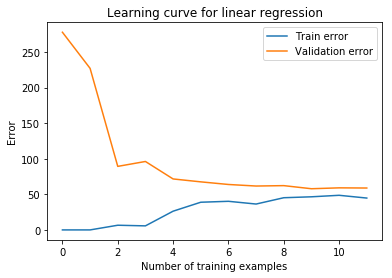

In [576]:
visualize_learning_curve(X, y, X_val, y_val, 10)

In [580]:
poly = PolynomialFeatures(2, include_bias=False)
X_poly = poly.fit_transform(X)
X_val_poly = poly.fit_transform(X_val)

[ 0.] [ 277.69355395]
[ 0.] [ 273.36323114]
[  2.23510590e-30] [ 12.59318164]
[ 0.14107047] [ 12.6566189]
[ 0.18731593] [ 15.30524814]
[ 0.62795037] [ 14.78345822]
[ 0.73580916] [ 14.53061618]
[ 1.09291219] [ 13.47125709]
[ 2.03939859] [ 13.7831235]
[ 1.84574767] [ 13.66302284]
[ 1.9105241] [ 13.98737876]
[ 2.03732231] [ 13.98929909]


F:\Anaconda__\lib\site-packages\sklearn\linear_model\ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
F:\Anaconda__\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 5.551115123125783e-17
  ' condition number: {}'.format(rcond), RuntimeWarning)


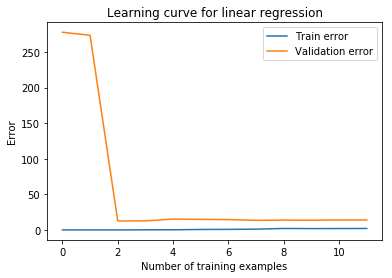

In [581]:
visualize_learning_curve(X_poly, y, X_val_poly, y_val, 0)